# Study of Covid data as published by the NYT

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import datetime
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY
%matplotlib inline

In [2]:
matplotlib.style.use('seaborn-whitegrid')

Set the style for the graphs

## Get NYT Data and prepare the data

In [3]:
df = pd.read_csv('us-states.csv')
df.tail()

,date,state,fips,cases,deaths
1659,2020-04-01,Virginia,51,1511,34
1660,2020-04-01,Washington,53,5588,249
1661,2020-04-01,West Virginia,54,191,2
1662,2020-04-01,Wisconsin,55,1550,33
1663,2020-04-01,Wyoming,56,137,0


### Make the dates strings into Timestamp objects

In [4]:
df['date']=df['date'].apply(lambda x:pd.Timestamp(x))
df.dtypes

date      datetime64[ns]
state             object
fips               int64
cases              int64
deaths             int64
dtype: object

For easier data slicing based on dates, make the date column the index

In [5]:
df.set_index('date',inplace=True)
df.head()

,state,fips,cases,deaths
date,,,,
2020-01-21,Washington,53,1,0
2020-01-22,Washington,53,1,0
2020-01-23,Washington,53,1,0
2020-01-24,Illinois,17,1,0
2020-01-24,Washington,53,1,0


### Plot the evolution of number of cases per state

In [6]:
def my_sate_cases_plotter(fig,ax,df,state,column):
    '''
    Helper function to make the graphs
    '''
    fig.set_size_inches(12,8)
    ax.set_title(f"Evolution of cases per State")
    # x locators and formatters
    ax.xaxis.set_major_locator(WeekdayLocator(MONDAY))
    ax.xaxis.set_minor_locator(DayLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%b-%d'))
    ax.xaxis.set_minor_formatter(DateFormatter('%d'))
    # y formatter for thousands separator
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,p: format(int(x),',')))
    out = ax.plot( df[df['state']==state].loc['20200301':].index , df[df['state']==state].loc['20200301':,[column]],label=state )
    ax.legend()
    return out

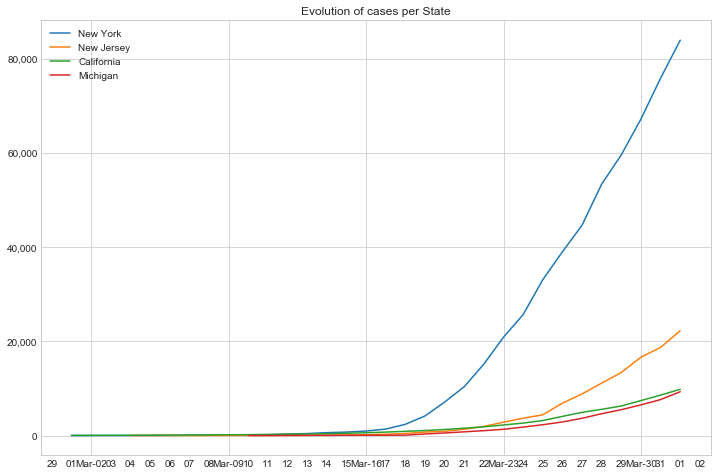

In [7]:
fig,ax = plt.subplots()
my_sate_cases_plotter(fig,ax,df,state='New York',column="cases")
my_sate_cases_plotter(fig,ax,df,state='New Jersey',column="cases")
my_sate_cases_plotter(fig,ax,df,state='California',column="cases")
out = my_sate_cases_plotter(fig,ax,df,state='Michigan',column="cases")

## Sates ranked per number of cases

In [8]:
last_timestamp = df.index.sort_values()[-1]

In [9]:

df[last_timestamp:].sort_values(by='cases',ascending=False).head(10)

,state,fips,cases,deaths
date,,,,
2020-04-01,New York,36,83889,1941
2020-04-01,New Jersey,34,22255,355
2020-04-01,California,6,9816,212
2020-04-01,Michigan,26,9293,336
2020-04-01,Florida,12,7765,100
2020-04-01,Massachusetts,25,7738,122
2020-04-01,Illinois,17,6980,146
2020-04-01,Louisiana,22,6424,273
2020-04-01,Pennsylvania,42,5805,74


## Number of New Cases per day (for a list of states)

In [10]:
states_list = ["New York","New Jersey","California","Michigan","Massachusetts","Florida","Washington","Illinois","Pennsylvania","Louisiana"]

In [11]:
df_states_list = []

In [12]:
# Iterate over all states, create the df and append to the list
for i,state in enumerate(states_list):
    # create a local copy of the df
    df_state = df[df.state == state].copy()
    # calculate the number of new cases per day
    df_state['new cases'] = df_state['cases'] - df_state['cases'].shift(1)
    df_state.fillna(0,inplace=True)
    # calculate SMA
    df_state['SMA'] = ( df_state['new cases'] + df_state['new cases'].shift(1) + df_state['new cases'].shift(2) )*1/3
    # append the df of that state to the list
    df_states_list.append(df_state)

In [13]:
df_states_list[0].tail()

,state,fips,cases,deaths,new cases,SMA
date,,,,,,
2020-03-28,New York,36,53363,782,8728.0,6765.666667
2020-03-29,New York,36,59568,965,6205.0,6860.333333
2020-03-30,New York,36,67174,1224,7606.0,7513.000000
2020-03-31,New York,36,75832,1550,8658.0,7489.666667
2020-04-01,New York,36,83889,1941,8057.0,8107.000000


### PLOT OF NEW CASES (for the 4 most impacted states)

In [14]:
def my_new_cases_plotter(df_list,states_list):

    nb_columns_fig = 2
    nb_rows_fig = 5
#     If more than 4 grapghs, extend the rows
#     if len(df_list) > 4:
#         nb_rows_fig = int((np.ceil(len(df_list) / nb_columns_fig)))
    
    fig, ax_arr = plt.subplots(nb_rows_fig, nb_columns_fig)  # create a figure with a 'rows x columns' grid of axes
    fig.set_size_inches(16,20)
    fig.suptitle("New cases registered per day")
    
    for df_index in range(len(df_list)):  # iterate over all the data frames to plot
    
        i_fig = int((np.floor(df_index / nb_columns_fig)))  # row position of the axes on that given figure
        j_fig = int((df_index % nb_columns_fig))  # column position of the axes on that given figure

        df = df_list[df_index].loc['20200301':]  # df to plot at that position

        ax_arr[i_fig,j_fig].bar(x=df['new cases'].index,height=df['new cases'],color="#900C3F")
        ax_arr[i_fig,j_fig].plot(df['new cases'].index,df['SMA'],color="#FFC300")

        ax_arr[i_fig,j_fig].xaxis.set_major_locator(WeekdayLocator(MONDAY))
        ax_arr[i_fig,j_fig].xaxis.set_minor_locator(DayLocator())
        ax_arr[i_fig,j_fig].xaxis.set_major_formatter(DateFormatter('%d'))
        ax_arr[i_fig,j_fig].xaxis.set_minor_formatter(DateFormatter('%d'))
        ax_arr[i_fig,j_fig].set_title(states_list[df_index])
        

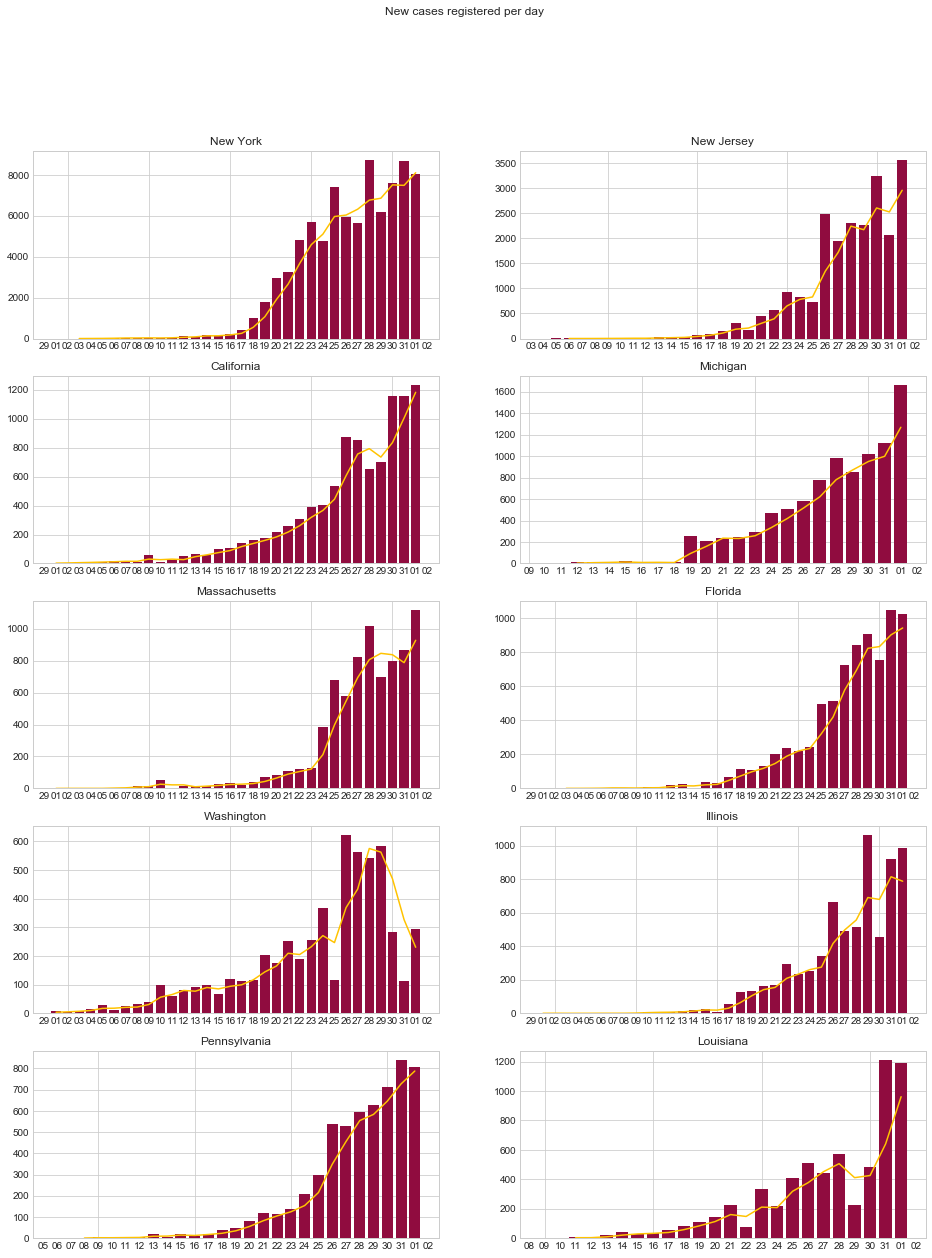

In [15]:
my_new_cases_plotter(df_states_list,states_list)